# Using LX-Quantitative to make a quantitative analysis of a text
This is an example notebook that illustrates how you can use the LX-Quantitative web service to
analyse a text.

**Before you run this example**, replace `access_key_goes_here` by your webservice access key, below:

In [1]:
LXQUANTITATIVE_WS_API_KEY = 'access_key_goes_here'
LXQUANTITATIVE_WS_API_URL = 'https://portulanclarin.net/workbench/lx-quantitative/api/'

## Importing required Python modules
The next cell will take care of installing the `requests` and `matplotlib` packages,
if not already installed, and make them available to use in this notebook.

In [2]:
try:
    import requests
except:
    !pip3 install requests
    import requests
try:
    import matplotlib.pyplot as plt
except:
    !pip3 install matplotlib
    import matplotlib.pyplot as plt
from IPython.display import HTML, display_html

## Wrapping the complexities of the JSON-RPC API in a simple, easy to use function

The `WSException` class defined below, will be used later to identify errors
from the webservice.

In [3]:
class WSException(Exception):
    'Webservice Exception'
    def __init__(self, errordata):
        "errordata is a dict returned by the webservice with details about the error"
        super().__init__(self)
        assert isinstance(errordata, dict)
        self.message = errordata["message"]
        # see https://json-rpc.readthedocs.io/en/latest/exceptions.html for more info
        # about JSON-RPC error codes
        if -32099 <= errordata["code"] <= -32000:  # Server Error
            if errordata["data"]["type"] == "WebServiceException":
                self.message += f": {errordata['data']['message']}"
            else:
                self.message += f": {errordata['data']!r}"
    def __str__(self):
        return self.message

The next function invoques the LX-Suite webservice through it's public JSON-RPC API.

In [4]:
def analyse(text, format):
    '''
    Arguments
        text: a string with a maximum of 2000 characters, Portuguese text, with
             the input to be processed
        format: either "text" or "JSON"

    Returns a string or JSON object with the output according to specification in
       https://portulanclarin.net/workbench/lx-quantitative/
    
    Raises a WSException if an error occurs.
    '''

    request_data = {
        'method': 'analyse',
        'jsonrpc': '2.0',
        'id': 0,
        'params': {
            'text': text,
            'format': format,
            'key': LXQUANTITATIVE_WS_API_KEY,
        },
    }
    request = requests.post(LXQUANTITATIVE_WS_API_URL, json=request_data)
    response_data = request.json()
    if "error" in response_data:
        raise WSException(response_data["error"])
    else:
        return response_data["result"]

Let us run the function we just defined:

In [5]:
text = '''
A final do Campeonato Europeu de Futebol de 2016 realizou-se em 10 de julho de 2016 no Stade de France
em Saint-Denis, França. Foi disputada entre Portugal e a França, que era a equipa anfitriã. Os portugueses
ganharam a partida e sagraram-se campeões europeus de futebol. Esta foi a segunda participação numa final
deste campeonato para Portugal e a terceira para a França. Os portugueses haviam participado anteriormente
nas edições de 1984 e em todas as edições desde 1996. O seu melhor resultado anterior foi em 2004, com o
título de vice-campeão. Já os franceses participaram em 1960, 1984 e em todas as edições desde 1992,
tendo-se sagrado campeões nas edições de 1984 e de 2000.
'''
result = analyse(text, format="JSON")

Let's display the result which is a `dict`.  Most values of this dictionary are numeric (`int` or `float`) but there is one which is itself a dict, which we will handle furhter ahead.

In [6]:
for key, value in sorted(result.items()):
    key = key.replace("_", " ")
    if key.endswith(" percentage"):
        key = key.replace(" percentage", "")
        print(f"{key}: {value:.02f}%")
    elif isinstance(value, float):
        print(f"{key}: {value:.04}")
    elif isinstance(value, int):
        print(f"{key}: {value}")
    #else:
    #    print(f"{key}: {value!r}")

coordenatives: 6
flesch: 24.25
letters: 559
letters in word average: 4.472
passive: 0.00%
passives: 0
phrases: 11
sentences: 7
subordinatives: 1
subordinatives: 9.09%
syllables: 243
syllables in word average: 1.944
unique tokens: 52.00%
words: 125
words in sentence average: 17.86


Let us use the `matplotlib` for displaying a lexical density pie chart from the `dict` associated with key `"lexical_density"`:

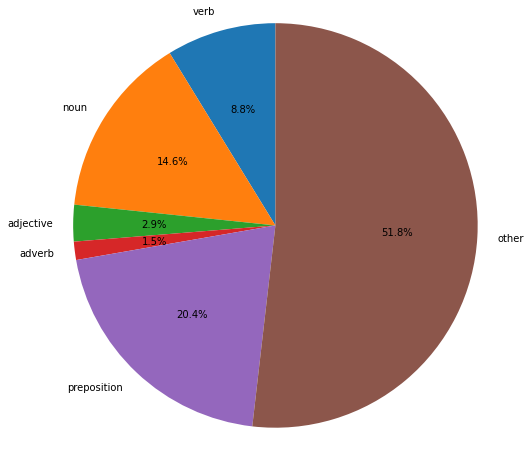

In [7]:
%matplotlib inline

# counts = {
#     cls.replace("_count", "").replace("_", " "): count
#     for cls, count in result["lexical_density"].items()
#     if cls.endswith("_count")
# }
percentages = {
    cls.replace("_percentage", "").replace("_", " "): percentage
    for cls, percentage in result["lexical_density"].items()
    if cls.endswith("_percentage")
}
total = sum(percentages.values())
if total < 100.0:
    percentages["other"] = 100.0 - total
labels = list(percentages.keys())
xs = [percentages[label] for label in labels]

plt.rcParams['figure.figsize'] = [8, 8]
fig1, ax1 = plt.subplots()
ax1.pie(xs, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
# To learn more about matplotlib visit https://matplotlib.org/

Let us print a table with word frequencies:

In [8]:
html = [
    "<table>",
    "<thead>",
    "<tr><th>Word</th><th>Frequency</th></tr>",
    "</thead>",
    "</tbody>",
]
for word, freq in result["tokens_freq"]:
    html.append(f"<tr><td>{word}</td><td>{freq}</td></tr>")
html.append("</tbody>")
html.append("</table>")
display_html(HTML("\n".join(html)))

Word,Frequency
de,12
em,10
a,7
e,6
as,4
edições,4
o,4
1984,3
foi,3
frança,3


## Getting the status of a webservice access key

In [9]:
def get_key_status():
    '''Returns a string with the detailed status of the webservice access key'''
    
    request_data = {
        'method': 'key_status',
        'jsonrpc': '2.0',
        'id': 0,
        'params': {
            'key': LXQUANTITATIVE_WS_API_KEY,
        },
    }
    request = requests.post(LXQUANTITATIVE_WS_API_URL, json=request_data)
    response_data = request.json()
    if "error" in response_data:
        raise WSException(response_data["error"])
    else:
        return response_data["result"]

In [10]:
get_key_status()

{'requests_remaining': 99999992,
 'chars_remaining': 999995190,
 'expiry': '2030-01-10T00:00+00:00'}